### 1. Start the Environment

We begin by installing and importing the necessary packages.

In [ ]:
!pip install ./python --user

In [16]:
1e-3

0.001

In [9]:
import os

from unityagents import UnityEnvironment
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
# from torch.utils.tensorboard import SummaryWriter

from ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [ ]:
# Load Environment
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]


### 3. Training

In [5]:
def train(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
#     writer = SummaryWriter('/home/aray/runs/continuous')  
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        # get the current state (for each agent)
        states = env_info.vector_observations
        score = 0
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += np.mean(rewards)
            if np.any(dones):
                break 
        # save most recent score
        scores_window.append(score) 
        # save most recent score
        scores.append(score)
#         writer.add_scalar('scores', score, i_episode)
        # save model
        torch.save(agent.actor_local.state_dict(), 'actro_checkpoint.pth')
        torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    
#     writer.close()            
    
    return scores

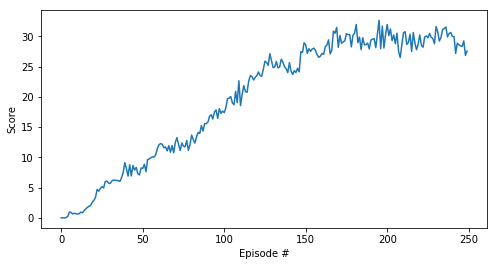

In [13]:
agent = Agent(state_size, action_size)
scores = train(agent, 250)

# plot the scores
fig = plt.figure(figsize=(8,4))
plt.plot(scores)
plt.ylabel('Score')
plt.xlabel('Episode #');

In [14]:
from model import Actor

def test(model_path,  n_episodes=100, max_t=1000):
    env_info = env.reset(train_mode=True)[brain_name]
    # size of each action
    action_size = brain.vector_action_space_size
    # examine the state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # load model
    model = Actor(state_size, action_size, seed=0).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    scores = np.zeros(n_episodes)
    scores_avg = np.zeros(n_episodes)

    scores_window = deque(maxlen=100)  # last 100 scores

    with torch.no_grad():
        for i in range(n_episodes):                                    
            env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
            states = env_info.vector_observations                  # get the current state (for each agent)
            states = torch.from_numpy(states).float().to(device)
            score = 0                                              # initialize the score (for each agent)
            for t in range(max_t):
                actions = model(states).cpu().numpy()              # select an action (for each agent)
                env_info = env.step(actions)[brain_name]           # send all actions to tne environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                next_states = torch.from_numpy(next_states).float().to(device)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if episode finished
                score += np.mean(rewards)                         # update the score (for each agent)
                states = next_states                               # roll over states to next time step
                if np.any(dones):                                  # exit loop if episode finished
                    break
            
            scores[i] = score
            # save most recent score
            scores_window.append(score)
            scores_avg[i] = np.mean(scores_window)
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i, np.mean(scores_window)), end="")
    return scores, scores_avg

Episode 99	Average Score: 35.19

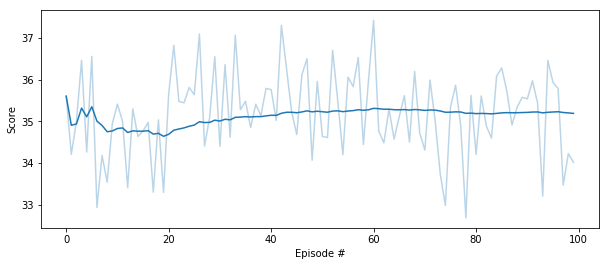

In [15]:
scores, avg = test('actor_checkpoint.pth')
fig = plt.figure(figsize=(10,4))
plt.plot(scores, color='C0', alpha=.3)
plt.plot(avg, color='C0')
plt.ylabel('Score')
plt.xlabel('Episode #');

When finished, you can close the environment.

In [5]:
env.close()